<a href="https://colab.research.google.com/github/ajeyamk/causalvae/blob/dev-ajeya/causal_vae_dsprites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Causal Variational Inference

### Introduction:
To train a supervised variational autoencoder using Deepmind's [dSprites](https://github.com/deepmind/dsprites-dataset) dataset.

dSprites is a dataset of sprites, which are 2D shapes procedurally generated from 5 ground truth independent "factors." These factors are color, shape, scale, rotation, x and y positions of a sprite.

All possible combinations of these variables are present exactly once, generating N = 737280 total images.

Factors and their values:

* Shape: 3 values {square, ellipse, heart}
* Scale: 6 values linearly spaced in (0.5, 1)
* Orientation: 40 values in (0, 2$\pi$)
* Position X: 32 values in (0, 1)
* Position Y: 32 values in (0, 1)


Further, the objective of any generative model is essentially to capture underlying data generative factors, the disentangled representation would mean a single latent unit being sensitive to variations in single generative factors


### Goal:
To include the latent factors  as labels in the training and to invent a causal story that relates these factors and the images in a DAG.

Reference 

[Structured Disentangled Representation](https://arxiv.org/pdf/1804.02086.pdf)

In [1]:
#Install dependencies
!pip3 install pyro-ppl
!pip3 install torch torchvision
!pip3 install pydrive --upgrade
!pip3 install tqdm

Requirement already up-to-date: pydrive in /usr/local/lib/python3.6/dist-packages (1.3.1)


In [0]:
# Load necessary libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import os
from collections import defaultdict

import torch
import torch.nn as nn

from tqdm import tqdm
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, EmpiricalMarginal
from pyro.optim import Adam, SGD
import torch.distributions.constraints as constraints

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#to utilize GPU capabilities
USE_CUDA = True

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

In [4]:
# Mount Google drive to load data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Mount G drive to access files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Hack to get all available GPU ram.

import tensorflow as tf
tf.test.gpu_device_name()

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 25.1 GB  | Proc size: 2.2 GB
GPU RAM Free: 11111MB | Used: 330MB | Util   3% | Total 11441MB


In [0]:
class Encoder(nn.Module):
	"""
    MLPs (multi-layered perceptrons or simple feed-forward networks)
    where the provided activation parameter is used on every linear layer except
    for the output layer where we use the provided output_activation parameter
	"""
	def __init__(self, image_dim, label_dim, z_dim):
		super(Encoder, self).__init__()
		#setup image and label dimensions from the dataset
		self.image_dim = image_dim
		self.label_dim = label_dim
		self.z_dim = z_dim
		# setup the three linear transformations used
		self.fc1 = nn.Linear(self.image_dim+self.label_dim, 1000)
		self.fc2 = nn.Linear(1000, 1000)
		self.fc31 = nn.Linear(1000, z_dim)  # mu values
		self.fc32 = nn.Linear(1000, z_dim)  # sigma values
		# setup the non-linearities
		self.softplus = nn.Softplus()

	def forward(self, xs, ys):
		xs = xs.reshape(-1, self.image_dim)
		#now concatenate the image and label
		inputs = torch.cat((xs,ys), -1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		# then return a mean vector and a (positive) square root covariance
		# each of size batch_size x z_dim
		z_loc = self.fc31(hidden2)
		z_scale = torch.exp(self.fc32(hidden2))
		return z_loc, z_scale


class Decoder(nn.Module):
	def __init__(self, image_dim, label_dim, z_dim):
		super(Decoder, self).__init__()
		# setup the two linear transformations used
		hidden_dim = 1000
		self.fc1 = nn.Linear(z_dim+label_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, hidden_dim)
		self.fc3 = nn.Linear(hidden_dim, hidden_dim)
		self.fc4 = nn.Linear(hidden_dim, image_dim)
		# setup the non-linearities
		self.softplus = nn.Softplus()
		self.sigmoid = nn.Sigmoid()

	def forward(self, zs, ys):
		inputs = torch.cat((zs, ys),-1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		hidden3 = self.softplus(self.fc3(hidden2))
		# return the parameter for the output Bernoulli
		# each is of size batch_size x 784
		loc_img = self.sigmoid(self.fc4(hidden3))
		return loc_img

In [0]:
class CVAE(nn.Module):
	"""
	This class encapsulates the parameters (neural networks) and models & guides 
	needed to train a supervised variational auto-encoder 
	"""
	def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):
    
		super(CVAE, self).__init__()
		self.image_dim = 64**2
		self.label_shape = np.array((1,3,6,40,32,32))
		self.label_names = np.array(('color', 'shape', 'scale', 'orientation', 'posX', 'posY'))
		self.label_dim = np.sum(self.label_shape)
		self.z_dim = 50                                           
		self.allow_broadcast = config_enum == 'parallel'
		self.use_cuda = use_cuda
		self.aux_loss_multiplier = aux_loss_multiplier
	    # define and instantiate the neural networks representing
	    # the paramters of various distributions in the model
		self.setup_networks()

	def setup_networks(self):
		"""
		Setup and initialize Encoder and decoder units
		"""
		self.encoder = Encoder(self.image_dim, self.label_dim, self.z_dim)
		self.decoder = Decoder(self.image_dim, self.label_dim, self.z_dim)
		# using GPUs for faster training of the networks
		if self.use_cuda:
		    self.cuda()

	def model(self, xs, ys):
		pyro.module("cvae", self)
		batch_size = xs.size(0)
		options = dict(dtype=xs.dtype, device=xs.device)
		with pyro.plate("data"):
			prior_loc = torch.zeros(batch_size, self.z_dim, **options)
			prior_scale = torch.ones(batch_size, self.z_dim, **options)
			zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))
			# if the label y (which digit to write) is supervised, sample from the
			# constant prior, otherwise, observe the value (i.e. score it against the constant prior)
			loc = self.decoder.forward(zs, self.remap_y(ys))
			pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
		  	# return the loc so we can visualize it later
			return loc

	def guide(self, xs, ys):
		with pyro.plate("data"):
			# sample (and score) the latent handwriting-style with the variational
			# distribution q(z|x) = normal(loc(x),scale(x))
			loc, scale = self.encoder.forward(xs, self.remap_y(ys))
			pyro.sample("z", dist.Normal(loc, scale).to_event(1))

	def remap_y(self, ys):
		new_ys = []
		options = dict(dtype=ys.dtype, device=ys.device)
		for i, label_length in enumerate(self.label_shape):
		    prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
		    new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
		                           obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
		new_ys = torch.cat(new_ys, -1)
		return new_ys.to(torch.float32)

	def reconstruct_image(self, xs, ys):
		# backward
		sim_z_loc, sim_z_scale = self.encoder.forward(xs, self.remap_y(ys))
		zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
		# forward
		loc = self.decoder.forward(zs, self.remap_y(ys))
		return dist.Bernoulli(loc).to_event(1).sample()

In [0]:
def setup_data_loaders(train_x, test_x, train_y, test_y, batch_size=128, use_cuda=False):
	train_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(train_y.astype(np.float32))
	)
	test_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(test_y.astype(np.float32))
	)    
	kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
	train_loader = torch.utils.data.DataLoader(
	  dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
	)

	test_loader = torch.utils.data.DataLoader(
	  dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
	)
	return {"train":train_loader, "test":test_loader}

In [0]:
dataset_zip = np.load(
    '/content/gdrive/My Drive/data-science/causal-ml/projects/dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
    encoding = 'bytes',
    allow_pickle=True
)

imgs = dataset_zip['imgs']
labels = dataset_zip['latents_classes']
label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
label_names = dataset_zip['metadata'][()][b'latents_names']

# Sample imgs randomly
indices_sampled = np.arange(imgs.shape[0])
np.random.shuffle(indices_sampled)
imgs_sampled = imgs[indices_sampled]
labels_sampled = labels[indices_sampled]

data_loaders = setup_data_loaders(
    imgs_sampled[1000:],
    imgs_sampled[:1000],
    labels_sampled[1000:],
    labels_sampled[:1000],
    batch_size=256,
    use_cuda=USE_CUDA
)

In [0]:
def train(svi, train_loader, use_cuda=False):
	# initialize loss accumulator
	epoch_loss = 0.
	# do a training epoch over each mini-batch x returned
	# by the data loader
	for xs,ys in train_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # do ELBO gradient and accumulate loss
	  epoch_loss += svi.step(xs, ys)
	# return epoch loss
	normalizer_train = len(train_loader.dataset)
	total_epoch_loss_train = epoch_loss / normalizer_train
	return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
	# initialize loss accumulator
	test_loss = 0.
	# compute the loss over the entire test set
	for xs, ys in test_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # compute ELBO estimate and accumulate loss
	  test_loss += svi.evaluate_loss(xs, ys)
	normalizer_test = len(test_loader.dataset)
	total_epoch_loss_test = test_loss / normalizer_test
	return total_epoch_loss_test

In [0]:
# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 10
TEST_FREQUENCY = 5

In [20]:
#################################
### FOR SAVING AND LOADING MODEL
################################
# clear param store

pyro.clear_param_store()

network_path = "/content/gdrive/My Drive/data-science/causal-ml/projects/trained_model.save"

PATH = "trained_model.save"

# new model
# vae = CVAE(use_cuda=USE_CUDA)

# save current model
# torch.save(vae.state_dict(), PATH)

# to load params from trained model
vae = CVAE(use_cuda=USE_CUDA)
vae.load_state_dict(torch.load(network_path))

<All keys matched successfully>

### **DONT RUN THE BELOW CODE AS WE'VE ALREADY TRAINED THE MODEL AND WE'VE STORED THE NETWORK PARAMS**

## ==================================================================================

In [0]:
import warnings
warnings.filterwarnings('ignore')

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = CVAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

VERBOSE = True
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, data_loaders["train"], use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    if VERBOSE:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loaders["test"], use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        if VERBOSE:
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

## ==================================================================================

## Visualizing the reconstruction accuracy of VAE

In [0]:
import warnings
warnings.filterwarnings("ignore")

data_iter = iter(data_loaders["train"])
xs, ys = next(data_iter)

if USE_CUDA:
    xs = xs.cuda()
    ys = ys.cuda()
rs = vae.reconstruct_image(xs, ys)
if USE_CUDA:
    xs = xs.cpu()
    rs = rs.cpu()
originals = xs.numpy().reshape(-1, 64,64)
recons = rs.reshape(-1,64,64)

In [24]:
# [ 0,  2,  1, 34,  4, 24]
def recon_check(original, recon):
  fig = plt.figure()
  ax0 = fig.add_subplot(121)
  plt.imshow(original, cmap='Greys_r',  interpolation='nearest')
  plt.axis('off')
  ax1 = fig.add_subplot(122)
  plt.imshow(recon , cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  
def f(x):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(originals[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recons[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    
interact(f, x=widgets.IntSlider(min=0, max=xs.shape[0], step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=256), Output()), _dom_classes=('widget-interact'…

<function __main__.f>

In [25]:
y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
y_shapes = np.array((3,6,40,32,32))
img_dict = {}

for i, img in enumerate(imgs_sampled):
     img_dict[tuple(labels_sampled[i])] = img

def find_in_dataset(shape, scale, orient, posX, posY):
  fig = plt.figure()
  img = img_dict[(0, shape, scale, orient, posX, posY)]
  plt.imshow(img.reshape(64,64), cmap='Greys_r', interpolation='nearest')
  plt.axis('off')

interact(find_in_dataset, 
         shape=widgets.IntSlider(min=0, max=2, step=1, value=0),
         scale=widgets.IntSlider(min=0, max=5, step=1, value=0),
         orient=widgets.IntSlider(min=0, max=39, step=1, value=0),
         posX=widgets.IntSlider(min=0, max=31, step=1, value=0),
         posY=widgets.IntSlider(min=0, max=31, step=1, value=0))

interactive(children=(IntSlider(value=0, description='shape', max=2), IntSlider(value=0, description='scale', …

<function __main__.find_in_dataset>

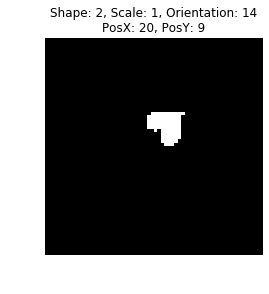

In [26]:
def get_specific_data(args=dict(), cuda=False):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        cuda - bool to indicate whether the output should be placed on GPU
    '''
    names_dict = {'shape': 1, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
    selected_ind = np.ones(imgs.shape[0], dtype=bool)
    for k,v in args.items():
        col_id = names_dict[k]
        selected_ind = np.bitwise_and(selected_ind, labels[:, col_id] == v)
    ind = np.random.choice(np.arange(imgs.shape[0])[selected_ind])
    x = torch.from_numpy(imgs[ind].reshape(1,64**2).astype(np.float32))
    y = torch.from_numpy(labels[ind].reshape(1,6).astype(np.float32))
    if not cuda:
        return x,y
    x = x.cuda()
    y = y.cuda()
    return x,y

def plot_image(x):
    """
    helper to plot dSprites images
    """
    x = x.cpu()
    plt.figure()
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

def see_specific_image(args=dict(), verbose=True):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        verbose - bool to indicate whether the full class label should be written 
                    as the title of the plot
    '''
    x,y = get_specific_data(args, cuda=False)
    plot_image(x)
    if verbose:
        string = ''
        for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
            string += '%s: %d, ' % (s, int(y[0][i+1]))
            if i == 2:
                string = string[:-2] + '\n'
        plt.title(string[:-2], fontsize=12)
        
def compare_reconstruction(original, recon):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array for recon image
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(recon.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstruction')
    
def compare_to_density(original, recons):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array of multiple recon images
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(torch.mean(recons.cpu(), 0).reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstructions')

        
see_specific_image()

In [27]:
label_dims = vae.label_shape
label_dim_offsets = np.cumsum(label_dims)
label_dim_offsets

array([  1,   4,  10,  50,  82, 114])

In [0]:
class SCM():
    """
    Structural causal model
    
    args: 
      vae: instance of vae
      mu: loc of q(z|x) given by the vae encoder
      sigma: scale of q(z|x) given by the vae encoder
    
    """
    def __init__(self, vae, mu, sigma):
        """
        Constructor
        
        Intializes :
          image dimensions - 4096(64*64), 
          z dimensions: size of the tensor representing the latent random variable z, 
          label dimensions: 114 labels y that correspond to an image(one hot encoded)
          f(x) = p(x|y,z)
          Noise variables in the model N_#
        """
        self.vae = vae
        self.image_dim = vae.image_dim
        self.z_dim = vae.z_dim
        # these are used for f_X
        self.label_dims = vae.label_shape
        
        def f_X(Y, Z, N):
            """
            p(z) = normal(0,I)              #(latent)
            p(y|x) = categorical(I/10.)     # which image
            p(x|y,z) = bernoulli(loc(y,z))   # posterior dist 
            """
            zs = Z.cuda()
            # convert the labels to one hot
            ys = [torch.tensor([0])]
            ys.append(torch.nn.functional.one_hot(Y[0].to(torch.long), int(self.label_dims[1])))
            ys.append(torch.nn.functional.one_hot(Y[1].to(torch.long), int(self.label_dims[2])))
            ys.append(torch.nn.functional.one_hot(Y[2].to(torch.long), int(self.label_dims[3])))
            ys.append(torch.nn.functional.one_hot(Y[3].to(torch.long), int(self.label_dims[4])))
            ys.append(torch.nn.functional.one_hot(Y[4].to(torch.long), int(self.label_dims[5])))
            ys = torch.cat(ys).to(torch.float32).reshape(1,-1).cuda()
            p = vae.decoder.forward(zs, ys)
            return (N < p.cpu()).type(torch.float)
        
        def f_Y(N):
            """
            Gumbel distribution - to model the distribution of the maximum of a number of samples
            m = Gumbel(torch.tensor([1.0]), torch.tensor([2.0])).sample() # sample from Gumbel distribution with loc=1, scale=2
            tensor([ 1.0124])
            
            https://pytorch.org/docs/stable/_modules/torch/distributions/gumbel.html
            """
#             m = torch.distributions.gumbel.Gumbel(torch.zeros(N.size(0)), torch.ones(N.size(0)))
            beta = 12
            indices = torch.tensor(np.arange(N.size(0))).to(torch.float32)
            smax = nn.functional.softmax(beta*N)
            argmax_ind = torch.sum(smax*indices)
            return argmax_ind
        
        def f_Z(N):
            """
            Z ~ Normal(mu, sigma) 
            """
            return N * sigma + mu
        
        def model(noise): 
            """
            The model corresponds to a generative process
            
            args: noise variables
            return: X(image), Y(labels), Z(latents) 
            """
            N_X = pyro.sample( 'N_X', noise['N_X'].to_event(1) )
            # denoted using the index in the sequence 
            # that they are stored in as vae.label_names:
            # ['shape', 'scale', 'orientation', 'posX', 'posY']
            N_Y_1 = pyro.sample( 'N_Y_1', noise['N_Y_1'].to_event(1) )
            N_Y_2 = pyro.sample( 'N_Y_2', noise['N_Y_2'].to_event(1) )
            N_Y_3 = pyro.sample( 'N_Y_3', noise['N_Y_3'].to_event(1) )
            N_Y_4 = pyro.sample( 'N_Y_4', noise['N_Y_4'].to_event(1) )
            N_Y_5 = pyro.sample( 'N_Y_5', noise['N_Y_5'].to_event(1) )
            
            # Z ~ Normal(Nx_mu, Nx_sigma)              
            N_Z = pyro.sample( 'N_Z', noise['N_Z'].to_event(1) )
            Z = pyro.sample('Z', dist.Normal( f_Z( N_Z ), 1e-1).to_event(1) )
            
            # Y ~ Gumbel max of Ny             
            Y_1_mu = f_Y(N_Y_1)
            Y_2_mu = f_Y(N_Y_2)
            Y_3_mu = f_Y(N_Y_3)
            Y_4_mu = f_Y(N_Y_4)
            Y_5_mu = f_Y(N_Y_5)
       
            Y_1 = pyro.sample('Y_1', dist.Normal( Y_1_mu, 1e-1) )
            Y_2 = pyro.sample('Y_2', dist.Normal( Y_2_mu, 1e-1) )
            Y_3 = pyro.sample('Y_3', dist.Normal( Y_3_mu, 1e-1) )
            Y_4 = pyro.sample('Y_4', dist.Normal( Y_4_mu, 1e-1) )
            Y_5 = pyro.sample('Y_5', dist.Normal( Y_5_mu, 1e-1) )
            
            Y_mu = (Y_1_mu, Y_2_mu, Y_3_mu, Y_4_mu, Y_5_mu)
            
            # X ~ p(x|y,z) = bernoulli(loc(y,z))             
            X = pyro.sample('X', dist.Normal( f_X( Y_mu, Z, N_X ), 1e-1).to_event(1))
            
            # return noise and variables
            noise_samples = N_X, (N_Y_1, N_Y_2, N_Y_3, N_Y_4, N_Y_5), N_Z
            variable_samples = X, (Y_1, Y_2, Y_3, Y_4, Y_5), Z

            return variable_samples, noise_samples
        
        self.model = model
        #Initialize all noise variables in the model         
        self.init_noise = {
            'N_X'   : dist.Uniform(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)),
            'N_Z'   : dist.Normal(torch.zeros(vae.z_dim), torch.ones(vae.z_dim)),
            'N_Y_1' : dist.Uniform(torch.zeros(label_dims[1]),torch.ones(self.label_dims[1])),
            'N_Y_2' : dist.Uniform(torch.zeros(label_dims[2]),torch.ones(self.label_dims[2])),
            'N_Y_3' : dist.Uniform(torch.zeros(label_dims[3]),torch.ones(self.label_dims[3])),
            'N_Y_4' : dist.Uniform(torch.zeros(label_dims[4]),torch.ones(self.label_dims[4])),
            'N_Y_5' : dist.Uniform(torch.zeros(label_dims[5]),torch.ones(self.label_dims[5]))            
        }
        
    def update_noise_svi(self, obs_data):
        """
        Assume all noise variables are normal distributions. Use svi to find out 
        the mu, sigma of the distributionsfor the condition outlined in obs_data
        """
        
        def guide(noise):
            """
            The guide serves as an approximation to the posterior p(z|x). 
            The guide provides a valid joint probability density over all the 
            latent random variables in the model.
            
            https://pyro.ai/examples/svi_part_i.html
            """
            # create params with constraints
            mu = {
                'N_X': pyro.param('N_X_mu', 0.5*torch.ones(self.image_dim),constraint = constraints.interval(0., 1.)),
                'N_Z': pyro.param('N_Z_mu',torch.zeros(self.z_dim),constraint = constraints.interval(-3., 3.)),
                'N_Y_1': pyro.param('N_Y_1_mu', 0.5*torch.ones(self.label_dims[1]),constraint = constraints.interval(0., 1.)),
                'N_Y_2': pyro.param('N_Y_2_mu', 0.5*torch.ones(self.label_dims[2]),constraint = constraints.interval(0., 1.)),
                'N_Y_3': pyro.param('N_Y_3_mu', 0.5*torch.ones(self.label_dims[3]),constraint = constraints.interval(0., 1.)),
                'N_Y_4': pyro.param('N_Y_4_mu', 0.5*torch.ones(self.label_dims[4]),constraint = constraints.interval(0., 1.)),
                'N_Y_5': pyro.param('N_Y_5_mu', 0.5*torch.ones(self.label_dims[5]),constraint = constraints.interval(0., 1.))
                }
            sigma = {
                'N_X': pyro.param('N_X_sigma', 0.1*torch.ones(self.image_dim),constraint = constraints.interval(0.0001, 0.5)),
                'N_Z': pyro.param('N_Z_sigma', torch.ones(self.z_dim),constraint = constraints.interval(0.0001, 3.)),
                'N_Y_1': pyro.param('N_Y_1_sigma', 0.1*torch.ones(self.label_dims[1]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_2': pyro.param('N_Y_2_sigma', 0.1*torch.ones(self.label_dims[2]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_3': pyro.param('N_Y_3_sigma', 0.1*torch.ones(self.label_dims[3]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_4': pyro.param('N_Y_4_sigma', 0.1*torch.ones(self.label_dims[4]),constraint = constraints.interval(0.0001, 0.5)),
                'N_Y_5': pyro.param('N_Y_5_sigma', 0.1*torch.ones(self.label_dims[5]),constraint = constraints.interval(0.0001, 0.5))
                }
            for noise_term in noise.keys():
                pyro.sample(noise_term, dist.Normal(mu[noise_term], sigma[noise_term]).to_event(1))
        
        # Condition the model         
        obs_model = pyro.condition(self.model, obs_data)
        pyro.clear_param_store()

        # Once we’ve specified a guide, we’re ready to proceed to inference. 
        # Now, this an optimization problem where each iteration of training takes  
        # a step that moves the guide closer to the exact posterior         
        svi = SVI(
            model= obs_model,
            guide= guide,
            optim= SGD({"lr": 1e-5, 'momentum': 0.1}),
            loss=Trace_ELBO(retain_graph=True)
        )
        
        num_steps = 1500
        samples = defaultdict(list)
        for t in range(num_steps):
            loss = svi.step(self.init_noise)
            if t % 100 == 0:
                print("step %d: loss of %.2f" % (t, loss))
            for noise in self.init_noise.keys():
                mu = '{}_mu'.format(noise)
                sigma = '{}_sigma'.format(noise)
                samples[mu].append(pyro.param(mu).detach().numpy())
                samples[sigma].append(pyro.param(sigma).detach().numpy())
        means = {k: torch.tensor(np.array(v).mean(axis=0)) for k, v in samples.items()}
        
        # update the inferred noise
        updated_noise = {
            'N_X'  : dist.Normal(means['N_X_mu'], means['N_X_sigma']),
            'N_Z'  : dist.Normal(means['N_Z_mu'], means['N_Z_sigma']),
            'N_Y_1': dist.Normal(means['N_Y_1_mu'], means['N_Y_1_sigma']),
            'N_Y_2': dist.Normal(means['N_Y_2_mu'], means['N_Y_2_sigma']),
            'N_Y_3': dist.Normal(means['N_Y_3_mu'], means['N_Y_3_sigma']),
            'N_Y_4': dist.Normal(means['N_Y_4_mu'], means['N_Y_4_sigma']),
            'N_Y_5': dist.Normal(means['N_Y_5_mu'], means['N_Y_5_sigma']),
        }
        return updated_noise
        
    def __call__(self):
        return self.model(self.init_noise)

## Sanity check: 1
### Making sure SCM works

tensor([[ 0.,  2.,  0.,  1., 20., 23.]], device='cuda:0')


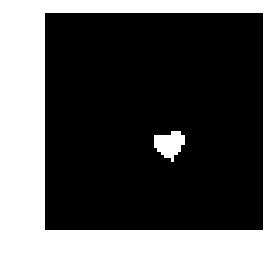

In [41]:
# Generate an instance of dSprites image 
ox, y = get_specific_data(cuda=True)
# Pass it through VAE to get q(z|x) => N(mu, sigma)
mu, sigma = vae.encoder.forward(ox,vae.remap_y(y))
# Feed these params to our custom SCM
scm = SCM(vae, mu.cpu(), sigma.cpu())
print(y)
# Check for reconstruction
plot_image(ox)

## Sanity check 2

### To check if the decoder is able to generate the image if the latents are changed:
#### To achieve this we manually change the labels in the code and run it through the decoder and check for reconstruction

top:  tensor([[ 0.,  0.,  2., 15., 24., 29.]], device='cuda:0')
bottom:  tensor([[ 0.,  1.,  2., 15., 24., 29.]], device='cuda:0')


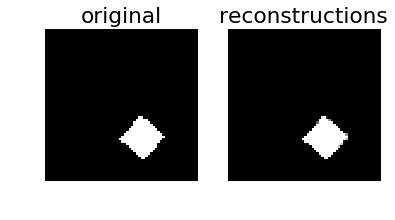

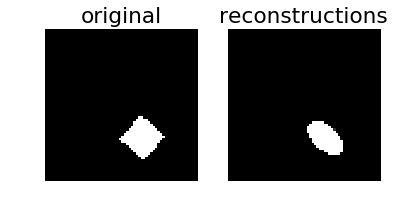

In [42]:
original, y_original = get_specific_data(cuda=True)
print('top: ',y_original)
mu, sigma = vae.encoder.forward(original,vae.remap_y(y_original))
B = 100
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_original) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)

y_new = torch.tensor(y_original)
y_new[0,1] = (y_original[0,1] + 1) % 2
print('bottom: ', y_new)
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
rs = vae.decoder.forward(zs.cuda(), ys).detach()
compare_to_density(original,rs)

In [43]:
intervened_model = pyro.do(scm.model, data={"Y_shape": torch.tensor(2.)})
cond_data = {}
for i in range(1, 6):
    cond_data["Y_{}".format(i)] = torch.tensor(y[0,i].cpu()).to(torch.float32)
conditioned_model = pyro.condition(scm.model, data=cond_data)
cond_noise = scm.update_noise_svi(cond_data)
print(cond_noise)

step 0: loss of 22670.87
step 100: loss of 654.15
step 200: loss of 922.37
step 300: loss of 1036.96
step 400: loss of 189.83
step 500: loss of 768.62
step 600: loss of inf
step 700: loss of inf
step 800: loss of inf
step 900: loss of 354.91
step 1000: loss of 291.25
step 1100: loss of -74.40
step 1200: loss of 204.67
step 1300: loss of 125.68
step 1400: loss of 179.87
{'N_X': Normal(loc: torch.Size([4096]), scale: torch.Size([4096])), 'N_Z': Normal(loc: torch.Size([50]), scale: torch.Size([50])), 'N_Y_1': Normal(loc: torch.Size([3]), scale: torch.Size([3])), 'N_Y_2': Normal(loc: torch.Size([6]), scale: torch.Size([6])), 'N_Y_3': Normal(loc: torch.Size([40]), scale: torch.Size([40])), 'N_Y_4': Normal(loc: torch.Size([32]), scale: torch.Size([32])), 'N_Y_5': Normal(loc: torch.Size([32]), scale: torch.Size([32]))}


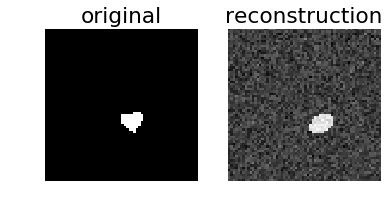

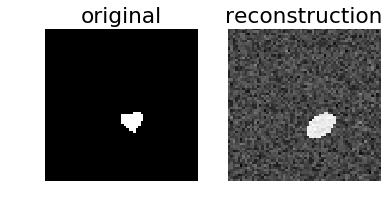

In [45]:
(cfo,_,_), _= scm.model(cond_noise)
compare_reconstruction(ox, cfo)


(cfo,_,_), _= intervened_model(cond_noise)
compare_reconstruction(ox, cfo)

## ======== Un charted territory  =======

In [38]:
import warnings
warnings.filterwarnings("ignore")

xs, ys = next(data_iter)
x = xs[0].reshape(1,-1).cuda()
y = ys[0].reshape(1,-1).cuda()
mu, sigma = vae.encoder.forward(x,vae.remap_y(y))
mu = mu.cpu()
sigma = sigma.cpu()
recon_x1, y1, z1 = OldSCM(vae, mu, sigma)
print(y1)

tensor([ 1.9037e-04,  9.9998e-01,  4.9999e+00, -1.2039e-04,  2.1000e+01,
         4.0000e+00])


In [0]:
def OldSCM(vae, mu, sigma):
    z_dim = vae.z_dim
    Ny, Y, ys = [], [], []
    Nx = pyro.sample("Nx", dist.Uniform(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)))
    Nz = pyro.sample("Nz", dist.Normal(torch.zeros(z_dim), torch.ones(z_dim)))
    m = torch.distributions.gumbel.Gumbel(torch.tensor(0.0), torch.tensor(1.0))
    for label_id in range(6):
        name = vae.label_names[label_id]
        length = vae.label_shape[label_id]
        new = pyro.sample("Ny_%s"%name, dist.Uniform(torch.zeros(length), torch.ones(length)) )
        Ny.append(new)
        gumbel_vars = torch.tensor([m.sample() for _ in range(length)])
        max_ind = torch.argmax(torch.log(new) + gumbel_vars).item()
        Y.append(pyro.sample("Y_%s"%name, dist.Normal(torch.tensor(max_ind * 1.0), 1e-4)))
#         Y.append(pyro.sample("Y_%s"%name, dist.Delta(torch.tensor(max_ind*1.0))))
        ys.append(torch.nn.functional.one_hot(torch.tensor(max_ind), int(length)))  
    Y = torch.tensor(Y)
    ys = torch.cat(ys).to(torch.float32).reshape(1,-1).cuda()
    Z = pyro.sample("Z", dist.Normal(mu + Nz*sigma, 1e-4))
#     Z = pyro.sample("Z", dist.Delta(mu + Nz*sigma))
    zs = Z.cuda()
    p = vae.decoder.forward(zs,ys)
    X = pyro.sample("X", dist.Normal((Nx < p.cpu()).type(torch.float), 1e-4))
#     X = pyro.sample("X", dist.Delta((Nx < p.cpu()).type(torch.float)))
    return X, Y, Z

tensor([-9.3067e-05,  0.0000e+00,  2.0000e+00,  3.9999e+00,  2.1000e+01,
         1.6000e+01])


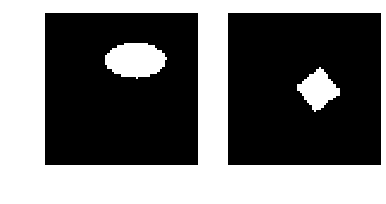

In [41]:
from pyro.infer.importance import Importance
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import HMC
from pyro.infer import SVI

intervened_model = pyro.do(OldSCM, data={"Y_shape": torch.tensor(0.)})
conditioned_model = pyro.condition(OldSCM, data={
    "X": recon_x1,
#     "Z": z1,
    "Y_color":y1[0],
    "Y_shape": y1[1],
    "Y_scale": y1[2],
    "Y_orientation": y1[3],
    "Y_posX": y1[4],
    "Y_posY": y1[5]
   })

#  change to svi
posterior = pyro.infer.Importance(conditioned_model, num_samples = 100)
posterior.run(vae, mu, sigma)

result = []
for i in range(500):
  trace = posterior()
  x = trace.nodes['Nx']['value']
  ny_shape = trace.nodes['Ny_shape']['value']
  ny_scale = trace.nodes['Ny_scale']['value']
  ny_orientation = trace.nodes['Ny_orientation']['value']
  ny_posX = trace.nodes['Ny_posX']['value']
  ny_posY = trace.nodes['Ny_posY']['value']
  z = trace.nodes['Nz']['value']
  con_obj = pyro.condition(intervened_model, data = {
      "Nx": x,
      "Ny_shape": ny_shape, 
      "Ny_scale": ny_scale, 
      "Ny_orientation": ny_orientation, 
      "Ny_posX": ny_posX, 
      "Ny_posY": ny_posY, 
      "Nz": z
  })
  
recon_x2,y2,z2 = con_obj(vae, mu, sigma)
print(y2)
recon_check(recon_x1.reshape(-1, 64, 64)[0], recon_x2.reshape(-1, 64, 64)[0])

In [0]:
result = []
for i in range(500):
  trace = posterior()
  x = trace.nodes['Nx']['value']
  ny_shape = trace.nodes['Ny_shape']['value']
  ny_scale = trace.nodes['Ny_scale']['value']
  ny_orientation = trace.nodes['Ny_orientation']['value']
  ny_posX = trace.nodes['Ny_posX']['value']
  ny_posY = trace.nodes['Ny_posY']['value']
  z = trace.nodes['Nz']['value']
  con_obj = pyro.condition(intervened_model, data = {
      "Nx": x,
      "Ny_shape": ny_shape, 
      "Ny_scale": ny_scale, 
      "Ny_orientation": ny_orientation, 
      "Ny_posX": ny_posX, 
      "Ny_posY": ny_posY, 
      "Nz": z
  })
  
recon_x2,y2,z2 = con_obj(vae, mu, sigma)
print(y2)
recon_check(recon_x1.reshape(-1, 64, 64)[0], recon_x2.reshape(-1, 64, 64)[0])

In [0]:
vae.label_names

In [32]:
adam_params = {"lr": 0.00042, "betas": (0.9, 0.999)}
optimizer = Adam(adam_params)
# set up the loss(es) for inference. wrapping the guide in config_enumerate builds
# the loss as a sum
# by enumerating each class label for the sampled discrete categorical distribution
# in the model
guide = config_enumerate(guide, "parallel", expand=True)
elbo = Trace_ELBO(max_plate_nesting=1)
loss_basic = SVI(sup_vae.model, guide, optimizer, loss=elbo)

# build a list of all losses considered
losses = [loss_basic]
loss_aux = SVI(sup_vae.model_classify, sup_vae.guide_classify, optimizer, loss=elbo)
losses.append(loss_aux)



from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

adam = Adam({"lr": 0.005, "betas": (0.90, 0.999)})
svi = SVI(vae.model, vae.guide, adam, loss=Trace_ELBO())


param_vals = []
pbar = tqdm(range(5))
for _ in pbar:
  xs, ys = next(data_iter)
  xs = xs.cuda()
  ys = ys.cuda()
  svi.step(xs, ys)
#   param_vals.append({k: param(k).item() for k in ["fl", "ia"]})

# pd.DataFrame(param_vals).plot(subplots=True)


  0%|          | 0/5 [00:00<?, ?it/s]

StopIteration: ignored